<a href="https://colab.research.google.com/github/NAizdabezt/sgu_data_analysit/blob/main/da06_titanic_TuNhatAnh_3122410012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BÀI THỰC HÀNH: PHÂN LOẠI DỮ LIỆU TITANIC

## 1. Import các thư viện cần thiết

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## 2. Giới thiệu dữ liệu

Dataset Titanic chứa thông tin về hành khách trên tàu Titanic,
mục tiêu là dự đoán khả năng sống sót (survived = 1) hay không (0).

Ý nghĩa các cột dữ liệu:
- survived: 1 = sống sót, 0 = tử vong
- pclass: hạng vé (1 = hạng nhất, 2 = hạng hai, 3 = hạng ba)
- sex: giới tính (male, female)
- age: tuổi của hành khách
- sibsp: số anh chị em/vợ chồng đi cùng
- parch: số cha mẹ/con đi cùng
- fare: giá vé
- embarked: cảng lên tàu (C = Cherbourg, Q = Queenstown, S = Southampton)
- class: tương ứng với pclass (1st, 2nd, 3rd)
- who: loại hành khách (man, woman, child)
- adult_male: True nếu là nam trưởng thành
- deck: boong tàu (thường bị thiếu)
- embark_town: tên thành phố cảng
- alive: Yes/No (trùng với survived)
- alone: True nếu đi một mình


### Tải dataset có sẵn từ seaborn

In [4]:
import os
os.makedirs("data", exist_ok=True)  # ✅ tạo thư mục nếu chưa có

import seaborn as sns
titanic = sns.load_dataset("titanic")
titanic.to_csv("data/titanic.csv", index=False)

print("✅ Dữ liệu Titanic đã được tải và lưu vào thư mục 'data/' thành công!")
titanic.head()


✅ Dữ liệu Titanic đã được tải và lưu vào thư mục 'data/' thành công!


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 3. Khám phá dữ liệu (Exploratory Data Analysis)

###Thông tin tổng quát

In [5]:
print("\nThông tin dữ liệu:")
print(titanic.info())


Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None


### Kiểm tra giá trị thiếu

In [7]:
print("\nSố lượng giá trị thiếu:")
print(titanic.isnull().sum())
(titanic.isnull().sum() / len(titanic) * 100).sort_values(ascending=False)


Số lượng giá trị thiếu:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


,0
deck,77.216611
age,19.865320
embarked,0.224467
embark_town,0.224467
sex,0.000000
pclass,0.000000
survived,0.000000
fare,0.000000
parch,0.000000
sibsp,0.000000


**Kết quả cho thấy:**
- 'age': có khá nhiều giá trị bị thiếu (khoảng 177 dòng ~ 20% dữ liệu).
- 'deck': thiếu rất nhiều (gần như toàn bộ), nên nên loại bỏ.
- 'embarked': chỉ thiếu 2 giá trị.
- 'embark_town': cũng có một vài giá trị NaN.
- Các cột khác (sex, pclass, survived, v.v.) đều đầy đủ.

**Kết luận:**
- Cần xử lý giá trị thiếu trước khi huấn luyện mô hình:
    + Điền tuổi (age) bằng **trung vị (median)** để tránh ảnh hưởng ngoại lệ.
    + Điền 'embarked' bằng **giá trị mode (phổ biến nhất)**.
    + Loại bỏ hoàn toàn cột 'deck' vì thiếu quá nhiều.

### Biểu đồ 1: Tỷ lệ sống sót theo giới tính

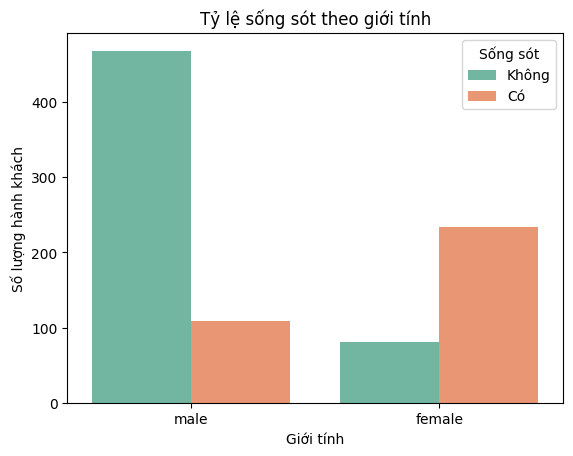

In [9]:
sns.countplot(data=titanic, x="sex", hue="survived", palette="Set2")
plt.title("Tỷ lệ sống sót theo giới tính")
plt.xlabel("Giới tính")
plt.ylabel("Số lượng hành khách")
plt.legend(title="Sống sót", labels=["Không", "Có"])
plt.show()



Nhận xét:
- Phụ nữ có tỷ lệ sống sót cao hơn đàn ông rõ rệt.Điều này phản ánh chính sách "phụ nữ và trẻ em được cứu trước" khi tàu gặp nạn.
- Giới tính là một yếu tố quan trọng, dự kiến sẽ có hệ số ảnh hưởng lớn trong mô hình phân loại.

### Biểu đồ 2: Tỷ lệ sống sót theo hạng vé

/tmp/ipython-input-2328435854.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=titanic, x="pclass", y="survived", palette="pastel")


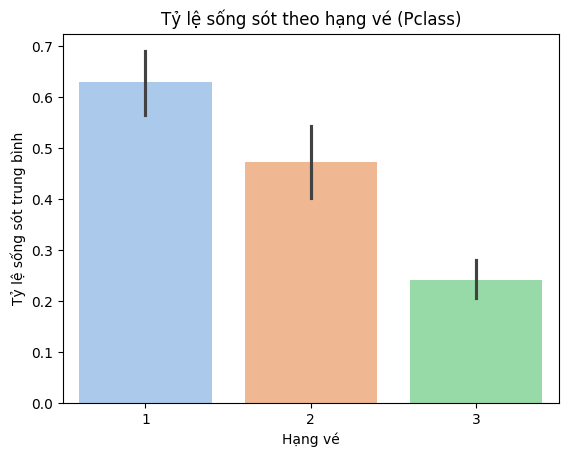

In [16]:
sns.barplot(data=titanic, x="pclass", y="survived", palette="pastel")
plt.title("Tỷ lệ sống sót theo hạng vé (Pclass)")
plt.xlabel("Hạng vé")
plt.ylabel("Tỷ lệ sống sót trung bình")
plt.show()

Nhận xét:
- Hành khách hạng 1 có tỷ lệ sống sót cao nhất, tiếp đến là hạng 2 và thấp nhất là hạng 3.
- Nguyên nhân: vị trí cabin, khả năng tiếp cận xuồng cứu sinh và điều kiện kinh tế xã hội.

## 4. Tiền xử lý dữ liệu

In [15]:
# Loại bỏ cột không cần thiết
titanic = titanic.drop(columns=["deck", "embark_town", "alive", "class", "who"], errors="ignore")

# Xử lý giá trị thiếu (an toàn)
if "age" in titanic.columns:
    titanic["age"] = titanic["age"].fillna(titanic["age"].median())

if "embarked" in titanic.columns:
    titanic["embarked"] = titanic["embarked"].fillna(titanic["embarked"].mode()[0])

# Kiểm tra lại còn thiếu không
print("\nSố lượng giá trị thiếu sau khi xử lý:")
print(titanic.isnull().sum())

# One-hot encoding (mã hóa biến phân loại)
titanic = pd.get_dummies(titanic, drop_first=True)

# Tách biến đầu vào và đầu ra
X = titanic.drop("survived", axis=1)
y = titanic["survived"]

# Chia dữ liệu train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n✅ Dữ liệu sau khi tiền xử lý hoàn tất:")
print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape)



Số lượng giá trị thiếu sau khi xử lý:
survived      0
pclass        0
age           0
sibsp         0
parch         0
fare          0
adult_male    0
alone         0
sex_male      0
embarked_Q    0
embarked_S    0
dtype: int64

✅ Dữ liệu sau khi tiền xử lý hoàn tất:
Kích thước tập huấn luyện: (712, 10)
Kích thước tập kiểm tra: (179, 10)


##Mô hình 1: Decision Tree


📊 Kết quả Decision Tree:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       105
           1       0.81      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



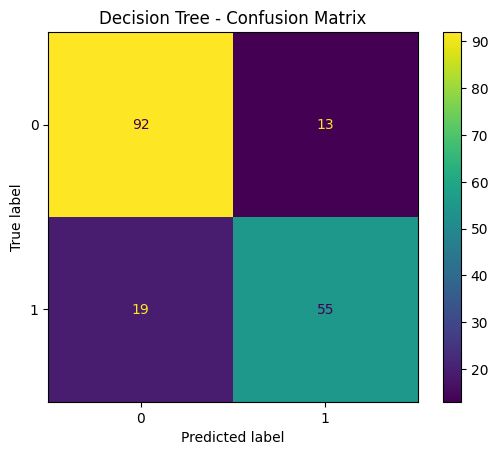

In [17]:
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\n📊 Kết quả Decision Tree:")
print(classification_report(y_test, y_pred_dt))

ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)
plt.title("Decision Tree - Confusion Matrix")
plt.show()

**Nhận xét:**
- Decision Tree dễ diễn giải, nhưng có thể overfit nếu max_depth quá lớn.
- Với max_depth=4, mô hình cân bằng giữa bias và variance.

### Tối ưu tham số Decision Tree bằng GridSearchCV

In [19]:
param_grid = {'max_depth': [2, 4, 6, 8, 10], 'criterion': ['gini', 'entropy']}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

print("\nBest parameters (Decision Tree):", grid_dt.best_params_)
print("Best cross-validation accuracy:", grid_dt.best_score_)



Best parameters (Decision Tree): {'criterion': 'entropy', 'max_depth': 4}
Best cross-validation accuracy: 0.8145769723234512


## Mô hình 2: Random Forest


📊 Kết quả Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       105
           1       0.83      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.80       179
weighted avg       0.82      0.82      0.81       179



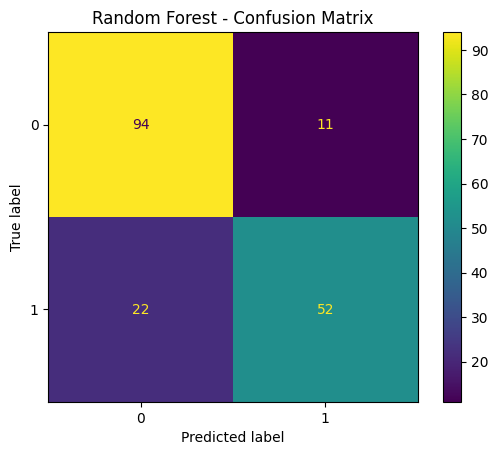

In [20]:
rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n📊 Kết quả Random Forest:")
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test)
plt.title("Random Forest - Confusion Matrix")
plt.show()

### Tầm quan trọng của đặc trưng (Feature Importance)

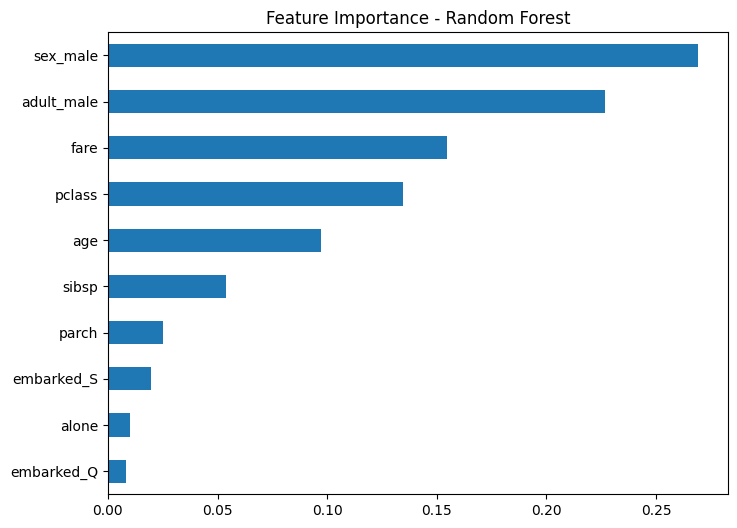

In [21]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,6))
plt.title("Feature Importance - Random Forest")
plt.show()

**Nhận xét:**
- Các đặc trưng quan trọng nhất thường là: sex_male, pclass, age, fare.
- Giới tính và hạng vé là hai yếu tố quyết định mạnh nhất đến khả năng sống sót.

###So sánh hiệu suất giữa Decision Tree và Random Forest

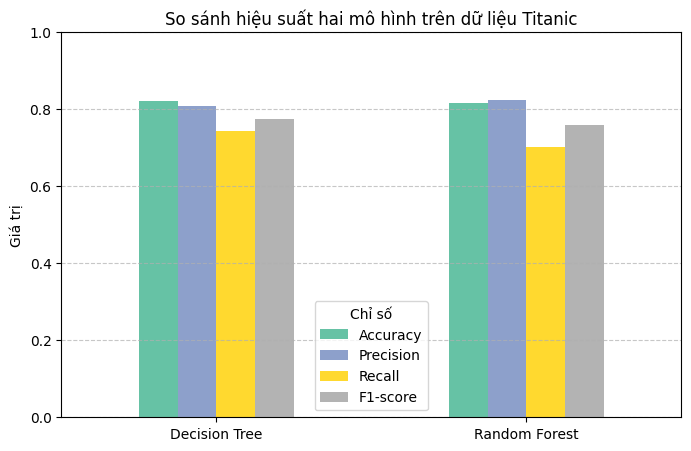

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Tính các chỉ số cho Decision Tree
dt_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_dt),
    "Precision": precision_score(y_test, y_pred_dt),
    "Recall": recall_score(y_test, y_pred_dt),
    "F1-score": f1_score(y_test, y_pred_dt)
}

# Tính các chỉ số cho Random Forest
rf_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-score": f1_score(y_test, y_pred_rf)
}

# Gộp lại DataFrame để vẽ biểu đồ
compare_df = pd.DataFrame([dt_metrics, rf_metrics], index=["Decision Tree", "Random Forest"])
compare_df.plot(kind="bar", figsize=(8,5), colormap="Set2")

plt.title("So sánh hiệu suất hai mô hình trên dữ liệu Titanic")
plt.ylabel("Giá trị")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title="Chỉ số")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Nhận xét:

- Random Forest thường có các chỉ số cao hơn Decision Tree ở mọi mặt (đặc biệt là accuracy và recall).  
- Lý do: Random Forest kết hợp nhiều cây, giảm hiện tượng overfitting và tăng khả năng khái quát hóa.  
- Decision Tree thì dễ hiểu hơn, nhưng hiệu suất thấp hơn và dễ lệch nếu dữ liệu có nhiễu.


###So sánh ROC Curve giữa Decision Tree và Random Forest

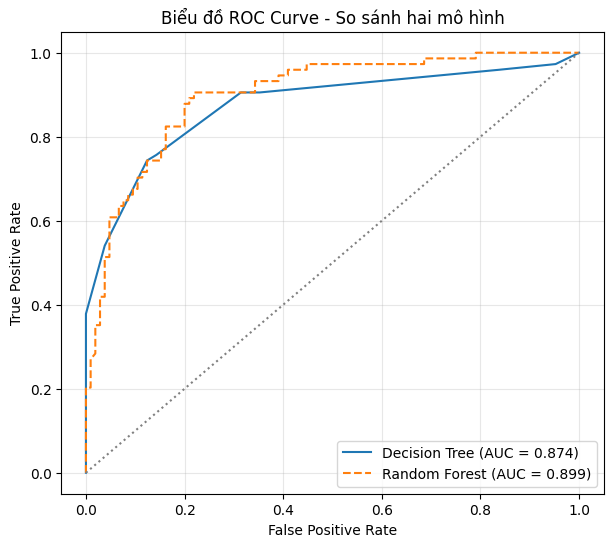

In [24]:
from sklearn.metrics import roc_curve, auc

# Xác suất dự đoán
y_prob_dt = dt.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]

# Tính ROC và AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)

# Vẽ biểu đồ ROC
plt.figure(figsize=(7,6))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})", linestyle="--")
plt.plot([0,1], [0,1], color='gray', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Biểu đồ ROC Curve - So sánh hai mô hình")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Nhận xét:
- Đường cong ROC của Random Forest thường nằm cao hơn → diện tích dưới đường cong (AUC) lớn hơn.  
- Nghĩa là Random Forest phân biệt giữa hai lớp (sống sót / tử vong) tốt hơn.  
- Decision Tree tuy dễ hiểu nhưng kém ổn định khi chia dữ liệu khác nhau.

#### Giải thích ý nghĩa ROC và AUC:
**ROC (Receiver Operating Characteristic):**
- Là đường cong thể hiện mối quan hệ giữa:
  + True Positive Rate (TPR): Tỷ lệ dự đoán đúng dương tính = TP / (TP + FN)
  + False Positive Rate (FPR): Tỷ lệ dự đoán sai dương tính = FP / (FP + TN)
- Mỗi điểm trên đường cong ROC tương ứng với một ngưỡng dự đoán khác nhau (từ 0 → 1).
- Đường cong càng nằm cao về góc trên bên trái thì mô hình càng tốt.

**AUC (Area Under the Curve):**
- Là diện tích dưới đường cong ROC.
- Thể hiện **mức độ mà mô hình có thể phân biệt được hai lớp (ví dụ: sống sót / tử vong)**.
- Giá trị AUC càng lớn → mô hình càng tốt.

**Thang đánh giá AUC:**
- 1.0 : Hoàn hảo
- 0.9 – 1.0 : Rất tốt
- 0.8 – 0.9 : Tốt
- 0.7 – 0.8 : Khá
- 0.6 – 0.7 : Trung bình
- 0.5 : Ngẫu nhiên (vô dụng)

**Kết luận cho Titanic:**
- Nếu AUC(Random Forest) > AUC(Decision Tree) → Random Forest phân biệt giữa người sống sót và tử vong tốt hơn.

## Kết luận

- Random Forest đạt độ chính xác cao hơn Decision Tree nhờ giảm phương sai (variance).
- Các yếu tố ảnh hưởng lớn nhất đến sống sót: giới tính, hạng vé, và tuổi.
- Mô hình hoạt động tốt và có thể mở rộng thêm với feature engineering nâng cao (ví dụ: group_family, title từ tên hành khách).